# 项目背景介绍
单发多框检测（SSD）模型简单、快速且被广泛使用。尽管这只是其中一种目标检测模型，但其中的一些设计原则和实现细节也适用于其他模型。







# 数据介绍
本项目采用香蕉检测数据集  
[来源](https://aistudio.baidu.com/aistudio/datasetdetail/124932)

In [15]:

# 解压数据集
!unzip -oq /home/aistudio/data/data124932/banana-detection.zip

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


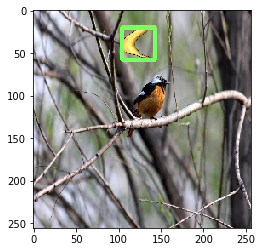

In [17]:
# 加载数据，可视化数据集中某一张图像：
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
for data, label in banana:
    image = data.numpy().transpose((1, 2, 0))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    label = label.numpy() * 256
    cv2.rectangle(image, (int(label[0][1]), int(label[0][2])), (int(label[0][3]), int(label[0][4])), (0, 255, 0), 4)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = (image * std + mean) * 255.0 # 反归一化
    image = image.astype('int64')
    plt.imshow(image)
    plt.show()
    break

# 模型介绍
单发多框检测模型的设计如下图所示。 此模型主要由基础网络组成，其后是几个多尺度特征块。 基本网络用于从输入图像中提取特征，因此它可以使用深度卷积神经网络。 单发多框检测论文中选用了在分类层之前截断的VGG，现在也常用ResNet替代。 我们可以设计基础网络，使它输出的高和宽较大。 这样一来，基于该特征图生成的锚框数量较多，可以用来检测尺寸较小的目标。 接下来的每个多尺度特征块将上一层提供的特征图的高和宽缩小（如减半），并使特征图中每个单元在输入图像上的感受野变得更广阔。
![](https://ai-studio-static-online.cdn.bcebos.com/28c92ddcb5a2482fbfd257696a54257b43f916eac949463a8f9770fc1a90f32e)
通过深度神经网络分层表示图像的多尺度目标检测的设计。 由于接近顶部的多尺度特征图较小，但具有较大的感受野，它们适合检测较少但较大的物体。 简而言之，通过多尺度特征块，单发多框检测生成不同大小的锚框，并通过预测边界框的类别和偏移量来检测大小不同的目标，因此这是一个多尺度目标检测模型。




## 预测层

In [ ]:
#导入库
%matplotlib inline
from matplotlib import pyplot as plt
import paddle
from paddle import nn
from paddle.nn import functional as F


In [13]:
# 类别预测层
def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2D(num_inputs, num_anchors * (num_classes + 1),
                     kernel_size=5, padding=2)

# 边界框预测层
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2D(num_inputs, num_anchors * 4, kernel_size=5, padding=2)

#连结多尺度的预测
def forward(x, block):
    return block(x)

Y1 = forward(paddle.zeros(shape=[2, 8, 20, 20]), cls_predictor(8, 5, 10))
Y2 = forward(paddle.zeros(shape=[2, 16, 10, 10]), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape

def flatten_pred(pred):
    return paddle.flatten(paddle.transpose(pred, perm=[0, 2, 3, 1]), start_axis=1)

def concat_preds(preds):
    return paddle.concat([flatten_pred(p) for p in preds], axis=-1)

concat_preds([Y1, Y2]).shape    


# 高和宽减半块
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2D(in_channels, out_channels,
                             kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2D(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2D(2))
    return nn.Sequential(*blk)

forward(paddle.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape
#基础网络块
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)

forward(paddle.zeros((2, 3, 256, 256)), base_net()).shape

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:653: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


[2, 64, 32, 32]

## 完整的模型

In [14]:
# 完整的模型
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2D((1,1))
    else:
        blk = down_sample_blk(128, 128)
    return blk


def box_corner_to_center(boxes):
    """Convert from (upper_left, bottom_right) to (center, width, height)"""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = paddle.stack((cx, cy, w, h), axis=-1)
    return boxes

def box_center_to_corner(boxes):
    """Convert from (center, width, height) to (upper_left, bottom_right)"""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = paddle.stack((x1, y1, x2, y2), axis=-1)
    return boxes


# Defined in file: ./chapter_computer-vision/bounding-box.md
def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""
    # Convert the bounding box (top-left x, top-left y, bottom-right x,
    # bottom-right y) format to matplotlib format: ((upper-left x,
    # upper-left y), width, height)
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)


# Defined in file: ./chapter_computer-vision/anchor.md
def multibox_prior(data, sizes, ratios):
    in_height, in_width = data.shape[-2:]
    num_sizes, num_ratios = len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = paddle.to_tensor(sizes)
    ratio_tensor = paddle.to_tensor(ratios)
    # Offsets are required to move the anchor to center of a pixel
    # Since pixel (height=1, width=1), we choose to offset our centers by 0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # Scaled steps in y axis
    steps_w = 1.0 / in_width  # Scaled steps in x axis

    # Generate all center points for the anchor boxes
    center_h = (paddle.arange(in_height) + offset_h) * steps_h
    center_w = (paddle.arange(in_width) + offset_w) * steps_w
    shift_y, shift_x = paddle.meshgrid(center_h, center_w)
    shift_y, shift_x = shift_y.reshape([-1]), shift_x.reshape([-1])

    # Generate boxes_per_pixel number of heights and widths which are later
    # used to create anchor box corner coordinates (xmin, xmax, ymin, ymax)
    # cat (various sizes, first ratio) and (first size, various ratios)
    w = paddle.concat((size_tensor * paddle.sqrt(ratio_tensor[0]),
                   sizes[0] * paddle.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width  # handle rectangular inputs
    h = paddle.concat((size_tensor / paddle.sqrt(ratio_tensor[0]),
                   sizes[0] / paddle.sqrt(ratio_tensor[1:])))
    # Divide by 2 to get half height and half width
    anchor_manipulations = paddle.tile(paddle.t(paddle.stack([-w, -h, w, h])), repeat_times=[in_height * in_width, 1]) /2

    # Each center point will have boxes_per_pixel number of anchor boxes, so
    # generate grid of all anchor box centers with boxes_per_pixel repeats
    out_grid = paddle.tile(paddle.stack([shift_x, shift_y, shift_x, shift_y],
                axis=1), repeat_times=[boxes_per_pixel, 1])

    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

class TinySSD(nn.Layer):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # 即赋值语句self.blk_i=get_blk(i)
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],
                                                    num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],
                                                      num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # getattr(self,'blk_%d'%i)即访问self.blk_i
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = paddle.concat(anchors, axis=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape([cls_preds.shape[0], -1, self.num_classes + 1])
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

net = TinySSD(num_classes=1)
X = paddle.zeros(shape=[32, 3, 256, 256])
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)        

output anchors: [1, 5444, 4]
output class preds: [32, 5444, 2]
output bbox preds: [32, 21776]


# 模型训练 

In [16]:
import os
import pandas as pd
import cv2
import numpy as np

def read_data_bananas(is_train=True):
    """Read the bananas dataset images and labels."""
    data_dir = 'banana-detection'
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                                    else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    mean = np.array(mean).reshape((1, 1, -1))
    std = np.array(std).reshape((1, 1, -1))
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        img = cv2.imread(os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}'))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = (img / 255.0 - mean) / std # 归一化
        img = img.astype('float32').transpose((2, 0, 1))
        images.append(img)
        # Since all images have same object class i.e. category '0',
        # the `label` column corresponds to the only object i.e. banana
        # The target is as follows : (`label`, `xmin`, `ymin`, `xmax`, `ymax`)
        targets.append(list(target))
    return paddle.to_tensor(images), paddle.to_tensor(targets).unsqueeze(1) / 256

class BananasDataset(paddle.io.Dataset):
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx], self.labels[idx])

    def __len__(self):
        return len(self.features)

banana =  BananasDataset(is_train=True)

read 1000 training examples


In [18]:
# 检查数据尺寸是否与期望输出一致：
train_loader = paddle.io.DataLoader(banana, batch_size=32, shuffle=True)
for batch_id, data in enumerate(train_loader()):
    x_data = data[0]
    y_data = data[1]

    print("image shape:{}".format(x_data.shape))
    print("label shape:{}".format(y_data.shape))
    break

image shape:[32, 3, 256, 256]
label shape:[32, 1, 5]


In [26]:
# 初始化其参数并定义优化算法。
net = TinySSD(num_classes=1)
trainer = paddle.optimizer.SGD(learning_rate=0.1, parameters=net.parameters(), weight_decay=5e-4)

定义损失函数和评价函数

In [27]:
cls_loss = nn.CrossEntropyLoss()
bbox_loss = nn.L1Loss()

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape([-1, num_classes]), cls_labels.reshape([-1]))
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks)
    return cls + bbox

def cls_eval(cls_preds, cls_labels):
    # 由于类别预测结果放在最后一维，argmax需要指定最后一维。
    return float((cls_preds.argmax(axis=-1) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((paddle.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())    

开始训练

In [28]:
def box_iou(boxes1, boxes2):
    boxes1, boxes2 = np.array(boxes1), np.array(boxes2)
    lt = np.maximum(boxes1[:, None, :2], boxes2[:, :2])
    rb = np.minimum(boxes1[:, None, 2:], boxes2[:, 2:])
    wh = np.maximum(rb - lt + 1, 0)
    inter = wh[:, :, 0] * wh[:, :, 1]
    areas1 = (boxes1[:, 2] - boxes1[:, 0] + 1) * (boxes1[:, 3] - boxes1[:, 1] + 1)
    areas2 = (boxes2[:, 2] - boxes2[:, 0] + 1) * (boxes2[:, 3] - boxes2[:, 1] + 1)
    iou = inter / (areas1[:, None] + areas2 - inter)
    return paddle.to_tensor(iou)

def match_anchor_to_bbox(ground_truth, anchors, iou_threshold=0.5):
    """Assign ground-truth bounding boxes to anchor boxes similar to them."""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # Element `x_ij` in the `i^th` row and `j^th` column is the IoU
    # of the anchor box `anc_i` to the ground-truth bounding box `box_j`
    jaccard = box_iou(anchors, ground_truth)
    # Initialize the tensor to hold assigned ground truth bbox for each anchor
    anchors_bbox_map = paddle.full((num_anchors,), -1, dtype="int64")
    # Assign ground truth bounding box according to the threshold
    max_ious = paddle.max(jaccard)
    indices = paddle.argmax(jaccard)
    anc_i = paddle.nonzero(max_ious >= 0.5)
    box_j = indices[0]
    anchors_bbox_map[anc_i] = box_j
    # Find the largest iou for each bbox
    col_discard = paddle.full((num_anchors,), -1)
    row_discard = paddle.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = paddle.argmax(jaccard)
        box_idx = paddle.cast(max_idx % num_gt_boxes, dtype='int64')# (max_idx % num_gt_boxes)#.long()
        anc_idx = paddle.cast(max_idx / num_gt_boxes, dtype='int64')# (max_idx / num_gt_boxes)#.long()
        anchors_bbox_map[anc_idx] = box_idx
    return anchors_bbox_map

def offset_boxes(anchors, assigned_bb, eps=1e-6):
    c_anc = box_corner_to_center(anchors)
    c_assigned_bb = box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * paddle.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = paddle.concat([offset_xy, offset_wh], axis=1)
    return offset

def multibox_target(anchors, labels):
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    num_anchors = anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = match_anchor_to_bbox(label[:, 1:], anchors)
        bbox_mask = (paddle.cast((anchors_bbox_map >= 0), dtype='float64').unsqueeze(-1))
        bbox_mask = paddle.tile(bbox_mask, repeat_times=[1, 4])
        # Initialize class_labels and assigned bbox coordinates with zeros
        class_labels = paddle.zeros([num_anchors], dtype="int64")
        assigned_bb = paddle.zeros([num_anchors, 4], dtype="float32")
        # Assign class labels to the anchor boxes using matched gt bbox labels
        # If no gt bbox is assigned to an anchor box, then let the
        # class_labels and assigned_bb remain zero, i.e the background class
        indices_true = paddle.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = paddle.cast(label[0][0], dtype="int64") + 1
        assigned_bb[indices_true] = label[0][1:]
        # offset transformations
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape([-1]))
        batch_mask.append(bbox_mask.reshape([-1]))
        batch_class_labels.append(class_labels)
    bbox_offset = paddle.stack(batch_offset)
    bbox_mask = paddle.stack(batch_mask)
    class_labels = paddle.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [57]:
num_epochs = 20

for epoch in range(num_epochs):
    # 训练精确度的和，训练精确度的和中的示例数
    # 绝对误差的和，绝对误差的和中的示例数
    metric = Accumulator(4)
    net.train()
    for i, (features, target) in enumerate(train_loader()):
        trainer.clear_grad()
        X, Y = features, target
        # 生成多尺度的锚框，为每个锚框预测类别和偏移量
        anchors, cls_preds, bbox_preds = net(X)
        # 为每个锚框标注类别和偏移量
        bbox_labels, bbox_masks, cls_labels = multibox_target(anchors, Y)
        # 根据类别和偏移量的预测和标注值计算损失函数
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    print(f'epoch: {epoch}, loss: {l.mean().numpy()[0]}, class err: {cls_err:.2e}, bbox mae: {bbox_mae:.2e}')

epoch: 0, loss: 0.005223007872700691, class err: 3.63e-04, bbox mae: 2.41e-03
epoch: 1, loss: 0.004531141370534897, class err: 3.62e-04, bbox mae: 2.41e-03
epoch: 2, loss: 0.005131514742970467, class err: 3.61e-04, bbox mae: 2.41e-03
epoch: 3, loss: 0.004924086853861809, class err: 3.59e-04, bbox mae: 2.40e-03
epoch: 4, loss: 0.004554016515612602, class err: 3.58e-04, bbox mae: 2.40e-03
epoch: 5, loss: 0.005349842831492424, class err: 3.55e-04, bbox mae: 2.40e-03
epoch: 6, loss: 0.004684170708060265, class err: 3.54e-04, bbox mae: 2.39e-03
epoch: 7, loss: 0.004359085112810135, class err: 3.54e-04, bbox mae: 2.39e-03
epoch: 8, loss: 0.005195909179747105, class err: 3.51e-04, bbox mae: 2.39e-03
epoch: 9, loss: 0.0057762679643929005, class err: 3.49e-04, bbox mae: 2.38e-03
epoch: 10, loss: 0.004806507378816605, class err: 3.49e-04, bbox mae: 2.38e-03
epoch: 11, loss: 0.005272676702588797, class err: 3.46e-04, bbox mae: 2.37e-03
epoch: 12, loss: 0.004402513615787029, class err: 3.42e-04, b

# 测试模型

In [58]:
# 加载测试集
banana_test = BananasDataset(is_train=False)

read 100 validation examples


In [59]:
# 获取预测边界框
def offset_inverse(anchors, offset_preds):
    c_anc = box_corner_to_center(anchors)
    c_pred_bb_xy = (offset_preds[:, :2] * c_anc[:, 2:] / 10) + c_anc[:, :2]
    c_pred_bb_wh = paddle.exp(offset_preds[:, 2:] / 5) * c_anc[:, 2:]
    c_pred_bb = paddle.concat((c_pred_bb_xy, c_pred_bb_wh), axis=1)
    predicted_bb = box_center_to_corner(c_pred_bb)
    return predicted_bb

def nms(boxes, scores, iou_threshold):
    # sorting scores by the descending order and return their indices
    B = paddle.argsort(scores, axis=-1, descending=True)
    keep = []  # boxes indices that will be kept
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() <= 1: break
        iou = box_iou(boxes.numpy()[i.numpy(), :].reshape([-1, 4]), boxes.numpy()[B.numpy()[1:], :].reshape([-1, 4])).reshape([-1])
        if paddle.nonzero(iou <= iou_threshold).shape[0] == 0: break
        inds = paddle.nonzero(iou <= iou_threshold).reshape([-1])
        B = B[inds + 1]
    return paddle.to_tensor(keep).reshape([-1])

def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.00999999978):
    batch_size = cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape([-1, 4])
        conf = paddle.max(cls_prob[1:], 0) # 置信度
        class_id = paddle.argmax(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, 0.5)
        all_idx = paddle.arange(num_anchors, dtype="int64")
        combined = paddle.concat([keep, all_idx], axis=0)
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = paddle.concat([keep, non_keep], axis=0)
        class_id[non_keep.stop_gradient] = -1.
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        # # print(conf, predicted_bb)
        # # threshold to be a positive prediction
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx.stop_gradient] = -1.
        conf[below_min_idx] = 1. - conf[below_min_idx]
        pred_info = paddle.concat([paddle.cast(class_id.unsqueeze(1), 'float32'), conf.unsqueeze(1), predicted_bb], axis=1)
        out.append(pred_info)
    return paddle.stack(out)

In [69]:

def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X)
    cls_probs = F.softmax(cls_preds, axis=2)
    cls_probs = paddle.transpose(cls_probs, perm=[0, 2, 1])
    output = multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output

test_loader = paddle.io.DataLoader(banana_test, batch_size=1, shuffle=True)
for batch_id, data in enumerate(test_loader()):
    X = data[0]
    Y = predict(X)
    break

# 模型评估

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
[-1.          0.99999994  0.5068309   0.3870402   0.6980898   0.65346664]


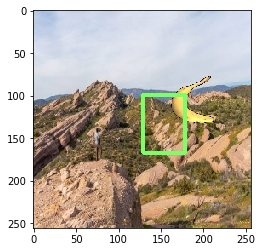

In [70]:
# 可视化检测结果
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
image = X[0].numpy().transpose((1, 2, 0))
print(image.shape)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
outputs = Y.numpy()[0]
results = []
for output in outputs:
    if (output[2] > 0. and output[2] < 1.) and (output[3] > 0. and output[3] < 1.) and (output[4] > 0. and output[4] < 1.) and (output[5] > 0. and output[5] < 1.) and output[1] < 1.:
        results.append(output)
results = np.array(results)
results = results[np.argsort(results[:,1])] # 按置信度的大小从小到大排序
output = results[-1] # 最后一个是置信度最大的
print(output)
cv2.rectangle(image, (int(output[2]*256), int(output[3]*256)), (int(output[4]*256), int(output[5]*256)), (0, 255, 0), 4)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = (image * std + mean) * 255.0 # 反归一化
image = image.astype('int64')
plt.imshow(image)
plt.show()

# 总结与升华

SSD是一种多尺度目标检测模型。基于基础网络块和各个多尺度特征块，能生成不同数量和不同大小的锚框，并通过预测这些锚框的类别和偏移量检测不同大小的目标。

在训练SSD检测模型时，损失函数是根据锚框的类别和偏移量的预测及标注值计算得出的

因为本人纯小白，此项目参考他人，如有侵权，评论我删除